In [34]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import copy

In [35]:
def show_images(image_dict, height=6):
    image_num = len(image_dict)
    width = np.ceil(height * 4 / 3) * image_num
    plt.figure(figsize=(width, height))
    for i in range(image_num):
        plt.subplot(1, image_num, i + 1)
        key = list(image_dict.keys())[i]
        plt.title(key)
        plt.imshow(image_dict[key], cmap='gray')

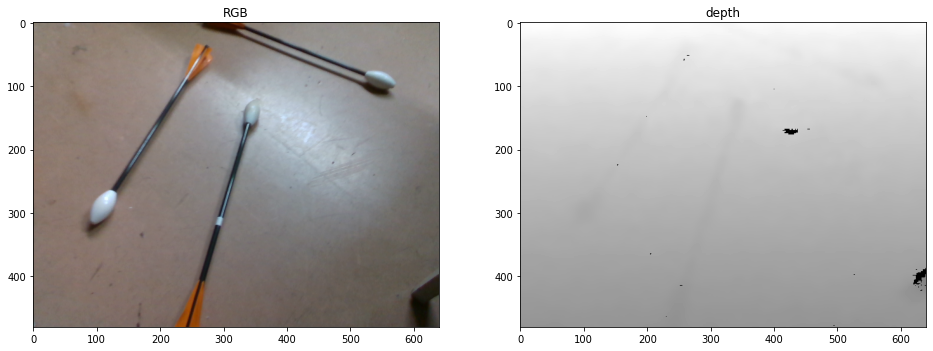

In [36]:
# image_num = 16087242258137402
image_num = 16087242271484966
image_color = cv2.imread('images/ground_arrow/color/color{}.png'.format(image_num))
image_depth = cv2.imread('images/ground_arrow/depth/depth{}.png'.format(image_num), cv2.IMREAD_ANYDEPTH)

image_color_RGB = cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB)
show_images({'RGB': image_color_RGB, 'depth': image_depth})

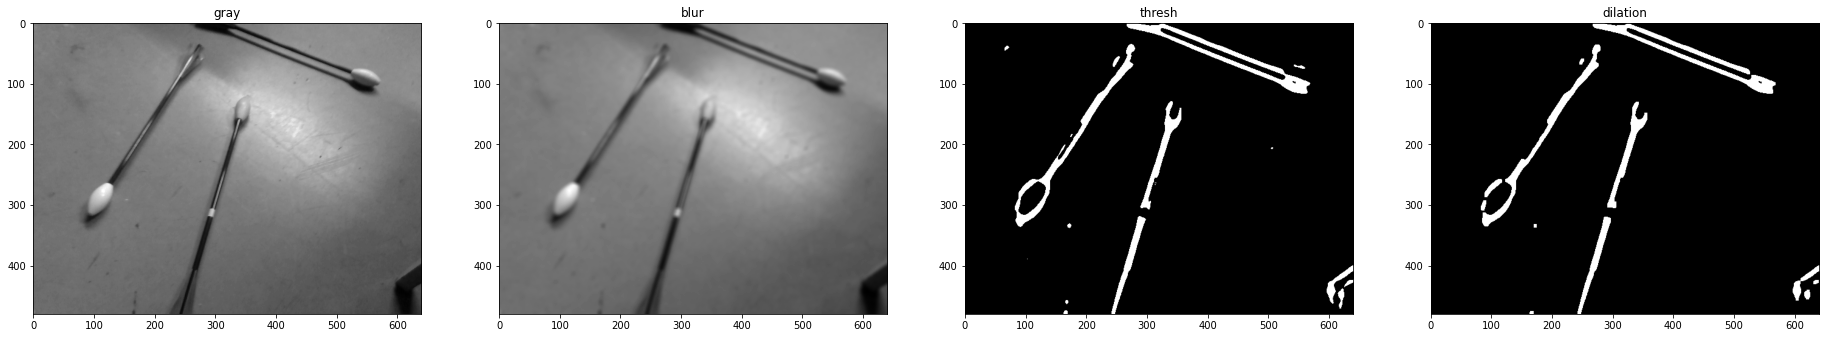

In [37]:
gray = cv2.cvtColor(image_color_RGB, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.blur(gray, (7, 7))
# ret, gray_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
gray_thresh = cv2.adaptiveThreshold(gray_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51, 9)

# noise removal
gray_thresh = cv2.medianBlur(gray_thresh, ksize=5)
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(gray_thresh, cv2.MORPH_OPEN, kernel, iterations=2)

kernel = np.ones((9, 9), np.uint8)
gray_dilation = cv2.dilate(gray_thresh, kernel, iterations=2)

show_images({'gray': gray, 'blur': gray_blur, 'thresh': gray_thresh, 'dilation': opening})

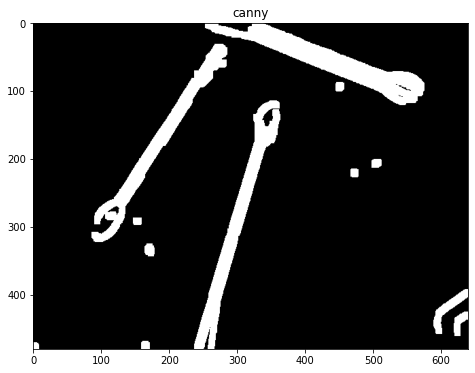

In [87]:
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
edges_dilation = cv2.dilate(edges, kernel, iterations=2)

show_images({'canny': edges_dilation})

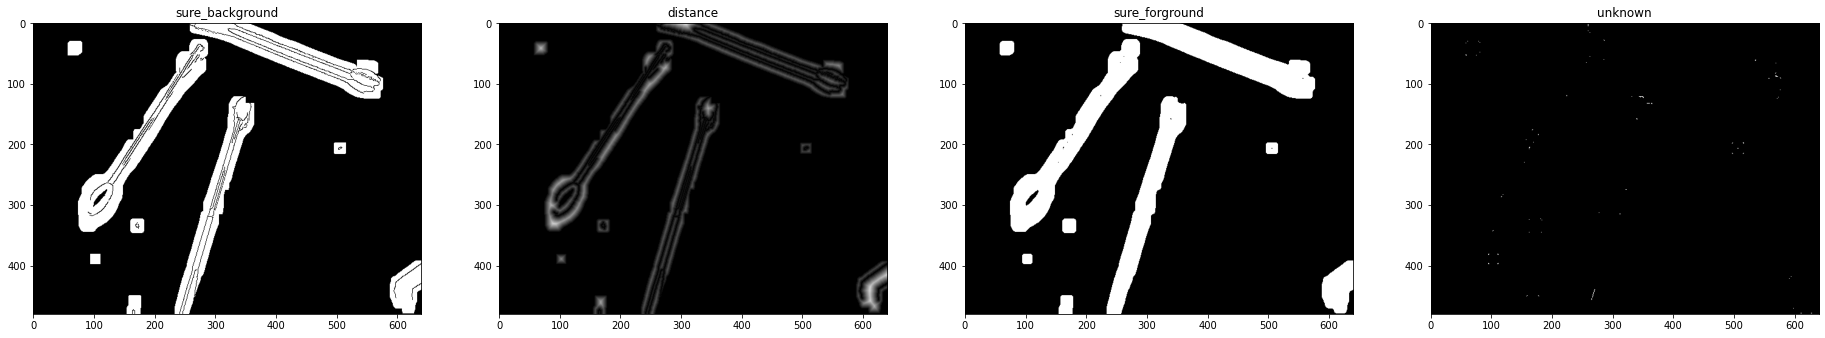

In [86]:
edges_inv = cv2.bitwise_not(edges)
sure_bg_line = cv2.bitwise_and(edges_inv, sure_bg)
dist_transform = cv2.distanceTransform(sure_bg_line, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.05 * dist_transform.max(), 255, 0)
sure_fg = cv2.medianBlur(sure_fg, ksize=5)
# kernel = np.ones((3, 3), np.uint8)
# sure_fg = cv2.morphologyEx(sure_fg, cv2.MORPH_OPEN, kernel, iterations=2)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

show_images({'sure_background': sure_bg_line, 'distance': dist_transform, 'sure_forground': sure_fg, 'unknown': unknown})

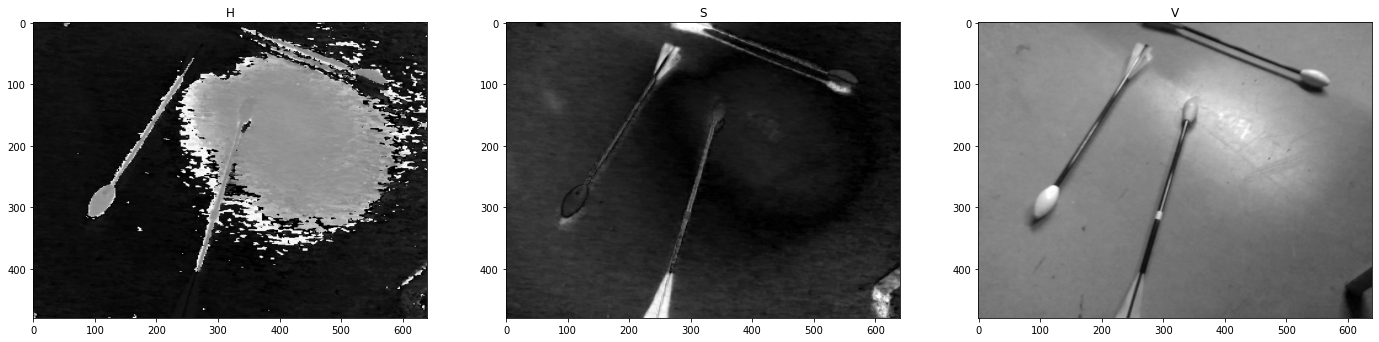

In [39]:
image_hsv = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)

show_images({'H': image_hsv[:, :, 0], 'S': image_hsv[:, :, 1], 'V': image_hsv[:, :, 2]})

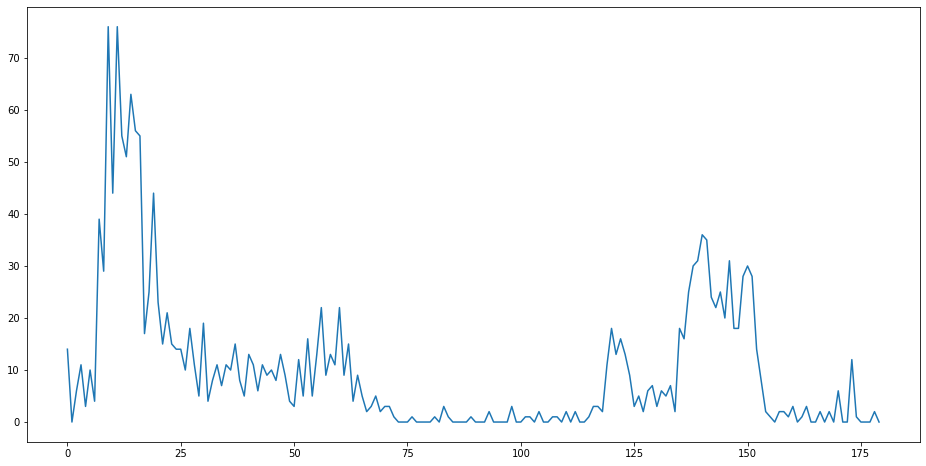

In [40]:
hist = cv2.calcHist(image_hsv, [0], None, [180], [0, 180])

plt.figure(figsize=(16, 8))
plt.plot(hist)

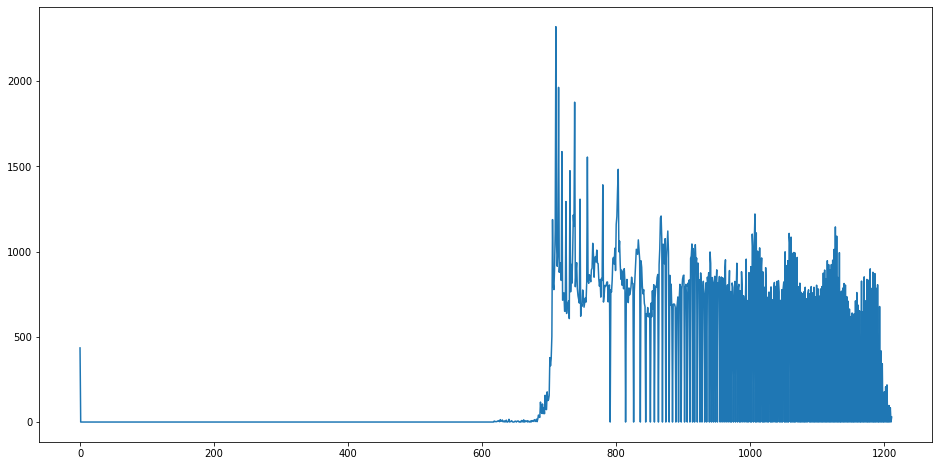

In [41]:
hist = np.bincount(image_depth.ravel(), minlength=256)

plt.figure(figsize=(16, 8))
plt.plot(hist)

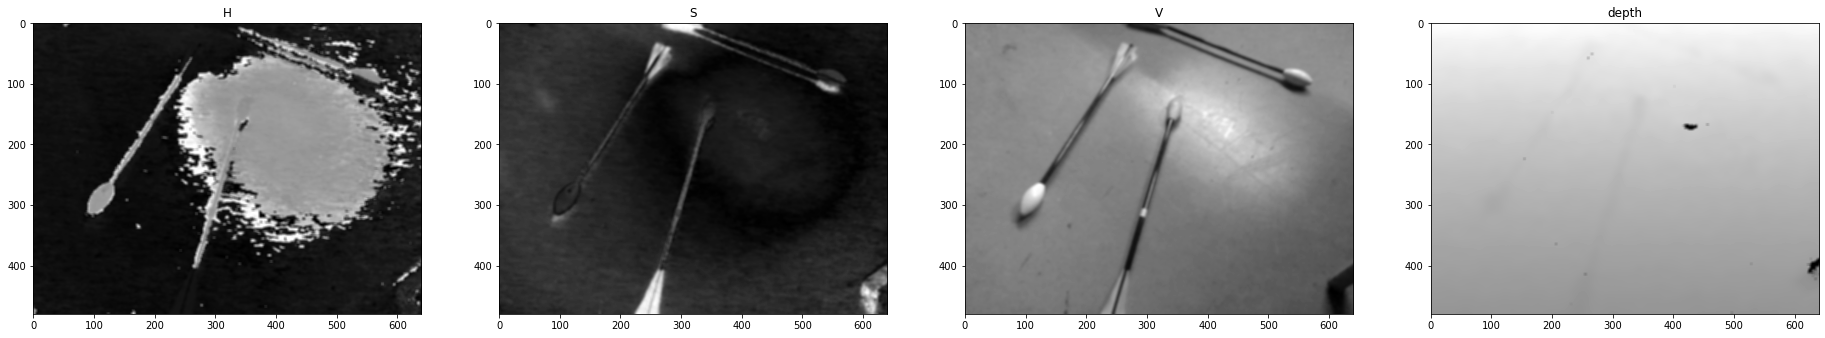

In [42]:
blur_hsv = cv2.blur(image_hsv, (5, 5))
blur_depth = cv2.blur(image_depth, (5, 5))

show_images({'H': blur_hsv[:, :, 0], 'S': blur_hsv[:, :, 1], 'V': blur_hsv[:, :, 2], 'depth': blur_depth})

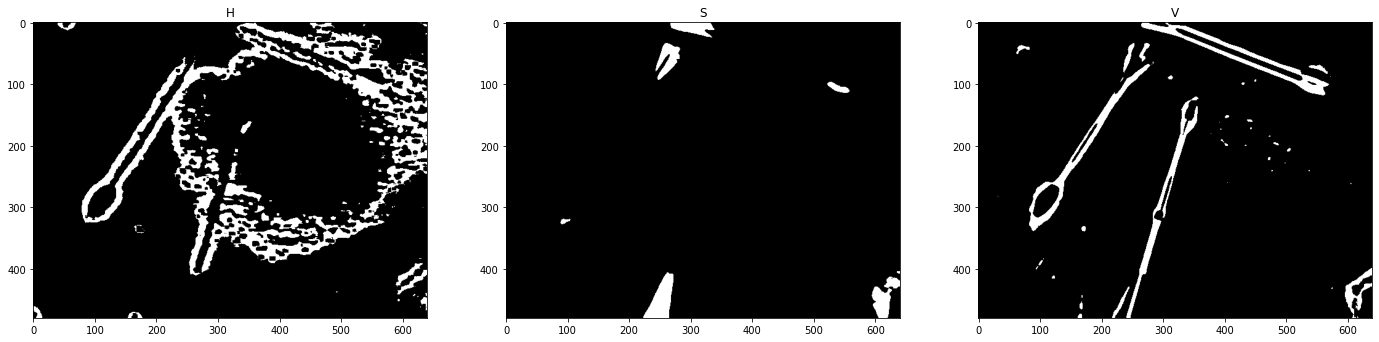

In [43]:
# ret, thresh_H = cv2.threshold(blur_hsv[:, :, 0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ret, thresh_S = cv2.threshold(blur_hsv[:, :, 1], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# ret, thresh_V = cv2.threshold(blur_hsv[:, :, 2], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
thresh_H = cv2.adaptiveThreshold(blur_hsv[:, :, 0], 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51, 9)
# thresh_S = cv2.adaptiveThreshold(blur_hsv[:, :, 1], 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51, 9)
thresh_V = cv2.adaptiveThreshold(blur_hsv[:, :, 2], 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51, 9)

show_images({'H': thresh_H, 'S': thresh_S, 'V': thresh_V})

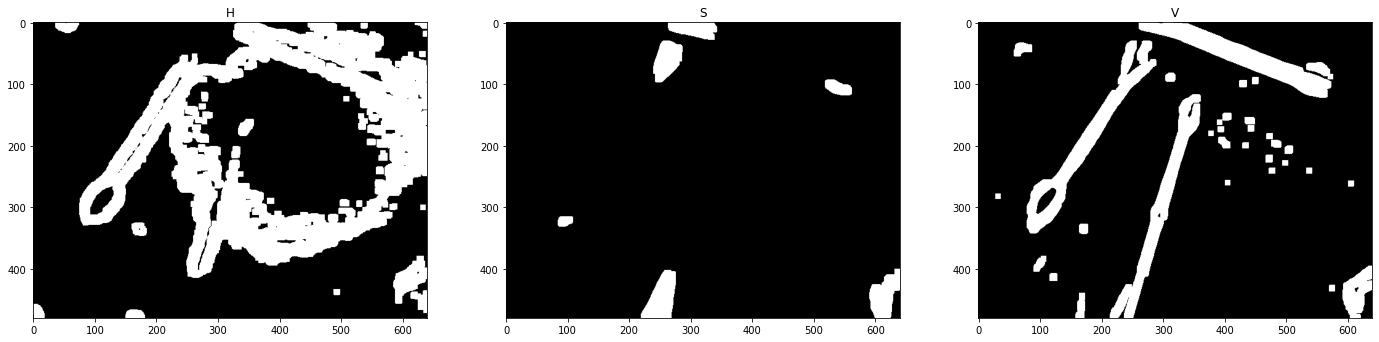

In [44]:
kernel = np.ones((5, 5), np.uint8)
thresh_dilation_H = cv2.dilate(thresh_H, kernel, iterations=2)
thresh_dilation_S = cv2.dilate(thresh_S, kernel, iterations=2)
thresh_dilation_V = cv2.dilate(thresh_V, kernel, iterations=2)

show_images({'H': thresh_dilation_H, 'S': thresh_dilation_S, 'V': thresh_dilation_V})

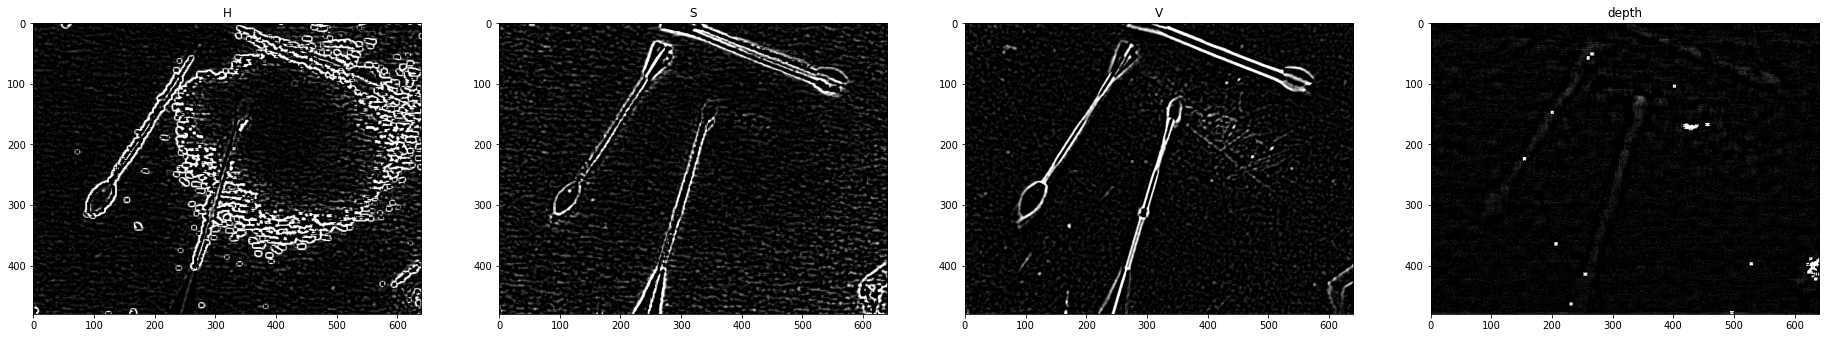

In [45]:
laplacian_hsv = cv2.Laplacian(blur_hsv, ddepth=cv2.CV_8U, ksize=5)
laplacian_depth = cv2.Laplacian(blur_depth, ddepth=cv2.CV_8U, ksize=5)

show_images({'H': laplacian_hsv[:, :, 0], 'S': laplacian_hsv[:, :, 1], 'V': laplacian_hsv[:, :, 2], 'depth': laplacian_depth})

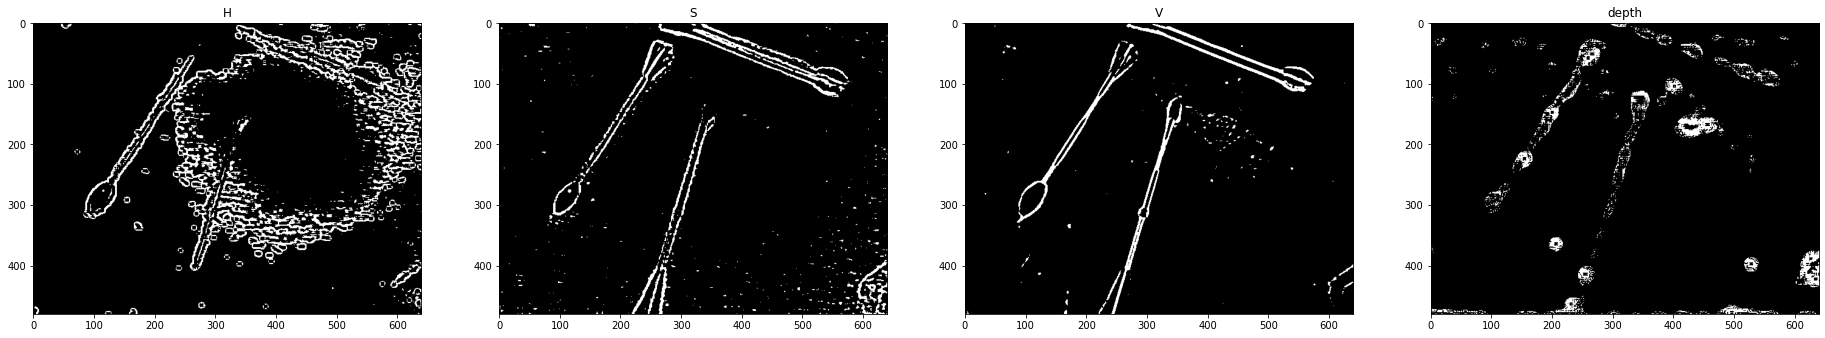

In [46]:
ret, laplacian_thresh_H = cv2.threshold(laplacian_hsv[:, :, 0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ret, laplacian_thresh_S = cv2.threshold(laplacian_hsv[:, :, 1], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ret, laplacian_thresh_V = cv2.threshold(laplacian_hsv[:, :, 2], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# ret, laplacian_thresh_depth = cv2.threshold(laplacian_depth, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
laplacian_thresh_depth = cv2.adaptiveThreshold(laplacian_depth, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 41, 10)

show_images({'H': laplacian_thresh_H, 'S': laplacian_thresh_S, 'V': laplacian_thresh_V, 'depth': laplacian_thresh_depth})

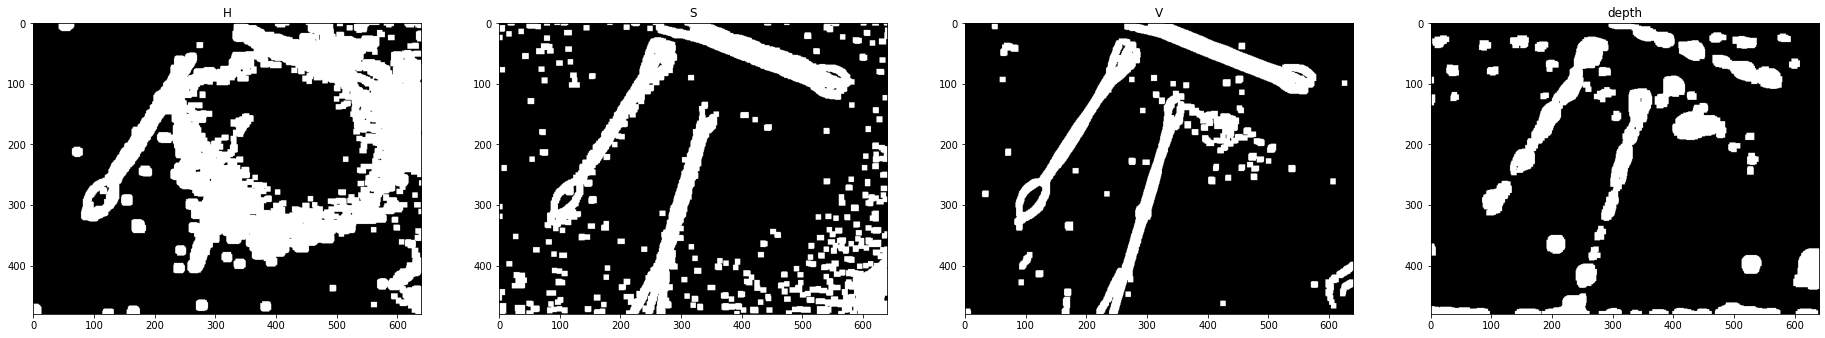

In [47]:
kernel = np.ones((5, 5), np.uint8)
laplacian_thresh_dilation_H = cv2.dilate(laplacian_thresh_H, kernel, iterations=2)
laplacian_thresh_dilation_S = cv2.dilate(laplacian_thresh_S, kernel, iterations=2)
laplacian_thresh_dilation_V = cv2.dilate(laplacian_thresh_V, kernel, iterations=2)
laplacian_thresh_dilation_depth = cv2.dilate(laplacian_thresh_depth, kernel, iterations=2)

show_images({'H': laplacian_thresh_dilation_H, 'S': laplacian_thresh_dilation_S, 'V': laplacian_thresh_dilation_V, 'depth': laplacian_thresh_dilation_depth})

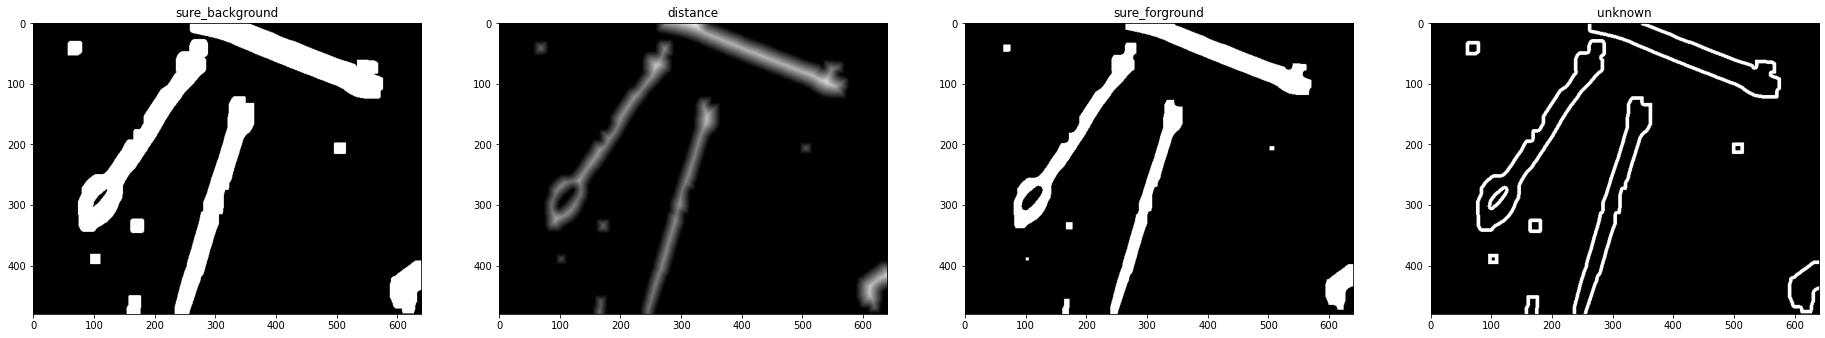

In [48]:
# sure_bg_line = cv2.bitwise_and(laplacian_thresh_depth, sure_bg)
# sure_bg = thresh_dilation_S
sure_bg = gray_dilation
dist_transform = cv2.distanceTransform(sure_bg, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)
# ret, sure_fg = cv2.threshold(dist_transform, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

show_images({'sure_background': sure_bg, 'distance': dist_transform, 'sure_forground': sure_fg, 'unknown': unknown})

In [75]:
def select_marker(markers):
    markers_selected = copy.deepcopy(markers)
    markers[markers == -1] = 0
    label_num = np.max(markers)
    for i in range(2, label_num + 1):
        mask = np.uint8(markers)
        mask[markers != i] = 0
        mask[markers == i] = 1

        point_num = np.sum(mask)
        if point_num < 500:
            markers_selected[mask == 1] = 1

    return markers_selected

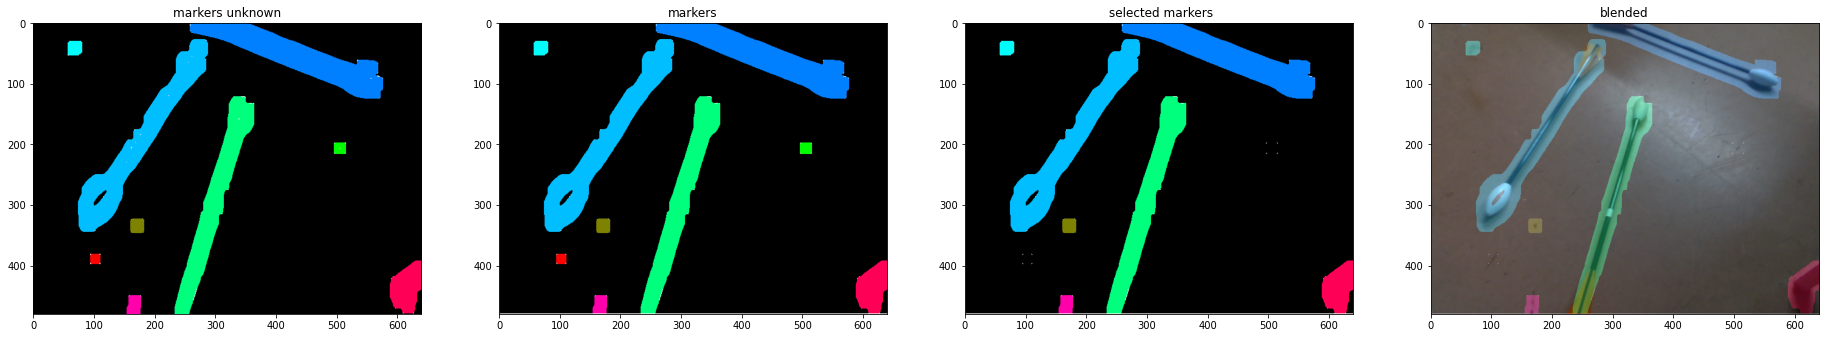

In [88]:
# Marker labelling
ret, markers_unknown = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers_unknown = markers_unknown + 1

# Now, mark the region of unknown with zero
markers_unknown[unknown==255] = 0

markers = copy.deepcopy(markers_unknown)
markers = cv2.watershed(image_color, markers)
markers_selected = select_marker(markers)

def marker2colormap(markers):
    markers_color = cv2.convertScaleAbs(markers, alpha=(255 / np.max(markers)))
    markers_color = cv2.applyColorMap(markers_color, cv2.COLORMAP_RAINBOW)
    markers_color[markers == -1] = [255, 255, 255]
    markers_color[markers == 0] = [255, 255, 255]
    markers_color[markers == 1] = [0, 0, 0]
    return markers_color

markers_unknown_color = marker2colormap(markers_unknown)
markers_color = marker2colormap(markers)
markers_selected_color = marker2colormap(markers_selected)

blended = cv2.addWeighted(
    src1=image_color_RGB,
    alpha=0.7,
    src2=markers_selected_color,
    beta=0.3,
    gamma=0)

show_images({'markers unknown': markers_unknown_color, 'markers': markers_color, ' selected markers': markers_selected_color, 'blended': blended})

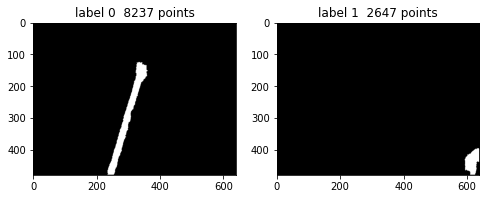

In [51]:
markers[markers == -1] = 0
label_num = np.max(markers)
mask_list = []
for i in range(2, label_num + 1):
    mask = np.uint8(markers)
    mask[markers != i] = 0
    mask[markers == i] = 1

    point_num = np.sum(mask)
    if 500 < point_num < 10000: mask_list.append(mask)

rowcol = np.ceil(np.sqrt(len(mask_list)))
height = rowcol * 4
width = np.ceil(height * 4 / 3)
plt.figure(figsize=(height, width))
for i in range(len(mask_list)):
    plt.subplot(rowcol, rowcol, i + 1)
    plt.title('label {}  {} points'.format(i, np.sum(mask_list[i])))
    plt.imshow(mask_list[i], cmap='gray')